In [1]:
!pip install -q finance-datareader

In [2]:
import os
import time

import pandas as pd
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy 
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (14,8)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True
plt.rcParams['axes.axisbelow'] = True

In [4]:
def get_data(sym):
    file_path = "/content/gdrive/MyDrive/stockData/"
    csv_path = os.path.join(file_path, f"{sym}.csv")
    df = pd.read_csv(csv_path, parse_dates=True, index_col = ['Date'])
    return df
    
def Min_Max_Scaler(dataframe):
    d_min = np.min(dataframe, 0)
    d_max = np.max(dataframe, 0)

    numerator = dataframe - d_min
    denominator = d_max - d_min

    df = numerator / (denominator + 1e-7)
    return df   

def return_data(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

# Data 탐색

In [5]:
sp500 = fdr.StockListing('S&P500')
sp500_list = list(sp500['Symbol'])

In [6]:
df_price = pd.DataFrame()

for i, data in sp500.iterrows():
    sym, name = data['Symbol'], data['Name']
    df =  get_data(sym)
    df_price[sym] = df['Close']

In [7]:
corr_price = df_price.corr()

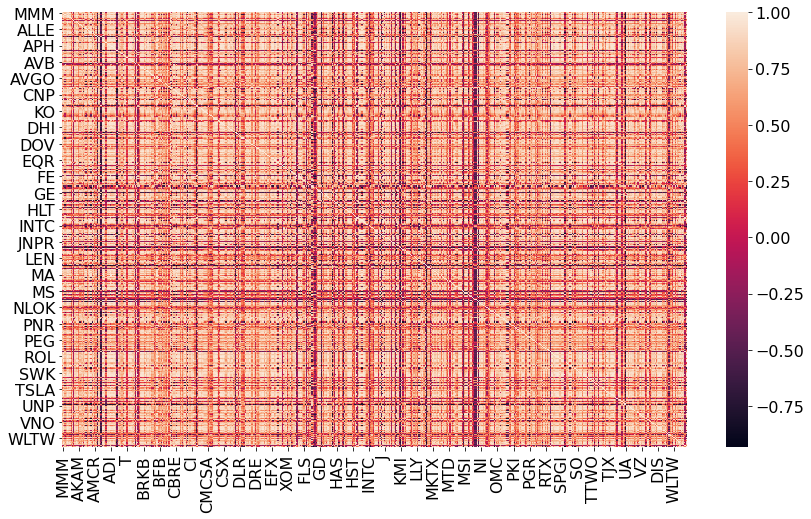

In [8]:
sns.heatmap(corr_price)

In [9]:
idx, vals = [], []

for ix, i in enumerate(corr_price.columns.values):
    for j in corr_price.columns.values[ix + 1:]:
        idx.append((i, j))
        vals.append(corr_price[i][j])

ser = pd.Series(data=vals, index=idx)
ser_ord = ser.sort_values(ascending=False)
ser_ord[:20]

(GOOGL, GOOG)     0.999738
(FOXA, FOX)       0.998016
(NWSA, NWS)       0.997661
(AWK, XEL)        0.994853
(ACN, ROP)        0.994644
(MSFT, MSCI)      0.994480
(MA, V)           0.994372
(UAA, UA)         0.994187
(INTU, MA)        0.994009
(AON, FIS)        0.992546
(ES, WEC)         0.992468
(DISCA, DISCK)    0.992446
(FIS, FISV)       0.992412
(ROP, V)          0.992346
(NEE, TMO)        0.991879
(IEX, ROP)        0.991867
(AMT, SBAC)       0.991649
(ACN, SHW)        0.991607
(COST, VRSK)      0.991473
(MCO, SPGI)       0.991428
dtype: float64

In [10]:
df = df_price.pct_change()

In [11]:
corr = df.corr()

In [12]:
idx, vals = [], []
for ix, i in enumerate(corr.columns.values):
    for j in corr.columns.values[ix + 1:]:
        idx.append((i, j))
        vals.append(corr[i][j])

ser2 = pd.Series(data=vals, index=idx)
ser_ord2 = ser2.sort_values(ascending=False)
ser_ord2[:20]

(GOOGL, GOOG)     0.993380
(FOXA, FOX)       0.988247
(NWSA, NWS)       0.979534
(UAA, UA)         0.971281
(DISCA, DISCK)    0.943776
(CFG, KEY)        0.906184
(CFG, RF)         0.900841
(CFG, FITB)       0.892085
(CFG, CMA)        0.883528
(AVB, EQR)        0.882870
(IR, TT)          0.882083
(HAL, SLB)        0.876674
(CFG, PNC)        0.873606
(CFG, TFC)        0.870997
(BXP, VNO)        0.867225
(CFG, HBAN)       0.863074
(FRT, REG)        0.860050
(KIM, REG)        0.858464
(AVB, ESS)        0.855730
(NCLH, RCL)       0.855270
dtype: float64

In [13]:
sp500.head()

,Symbol,Name,Sector,Industry
0,MMM,3M Company,Industrials,Industrial Conglomerates
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment
2,ABBV,AbbVie Inc.,Health Care,Pharmaceuticals
3,ABMD,ABIOMED Inc,Health Care,Health Care Equipment
4,ACN,Accenture plc,Information Technology,IT Consulting & Other Services


In [17]:
group = sp500.groupby('Sector')

In [18]:
group.count()

,Symbol,Name,Industry
Sector,,,
Communication Services,26,26,26
Consumer Discretionary,62,62,62
Consumer Staples,32,32,32
Energy,25,25,25
Financials,65,65,65
Health Care,63,63,63
Industrials,73,73,73
Information Technology,73,73,73
Materials,28,28,28


In [19]:
sector_list = list(set(sp500['Sector']))
sector_list

['Information Technology',
 'Industrials',
 'Health Care',
 'Utilities',
 'Consumer Discretionary',
 'Financials',
 'Consumer Staples',
 'Energy',
 'Communication Services',
 'Real Estate',
 'Materials']

In [20]:
sector_dict = {}

for sector in sector_list:
    sector_dict[sector] = list(sp500[sp500['Sector'] == sector]['Symbol'])

In [64]:
import shutil

for sector in sector_list:
    newpath = f'/content/gdrive/MyDrive/stockData/{sector}/'
    if not os.path.isdir(newpath):
        os.mkdir(newpath)

    savedpath = "/content/gdrive/MyDrive/stockData/"
    
    for sym in sector_dict[sector]:
        file_name = f"{sym}.csv"
        shutil.copy(savedpath+file_name, newpath+file_name)

In [21]:
def get_sector_data(sector, sym):
    file_path = f"/content/gdrive/MyDrive/stockData/{sector}"
    csv_path = os.path.join(file_path, f"{sym}.csv")
    df = pd.read_csv(csv_path, parse_dates=True, index_col = ['Date'])
    return df

In [22]:
by_sector = []

for sector in sector_list:
    df_price = pd.DataFrame()
    for sym in sector_dict[sector]:
        df = get_sector_data(sector, sym)
        df_price[sym] = df['Close']
    by_sector.append(df_price)

In [68]:
sector_list[-5]

'Consumer Staples'

In [23]:
temp = []

for data in by_sector:
    corr = data.corr()
    temp.append(corr)

In [24]:
for i in range(len(temp)):
    print(temp[i].mean().mean())

0.7019690383296021
0.673470412403942
0.729901024962964
0.6150139471582519
0.49054688689239223
0.46029916082933353
0.7323365804647016
0.5380236421283643
0.29697174269178533
0.6255936140900038
0.509469681247501


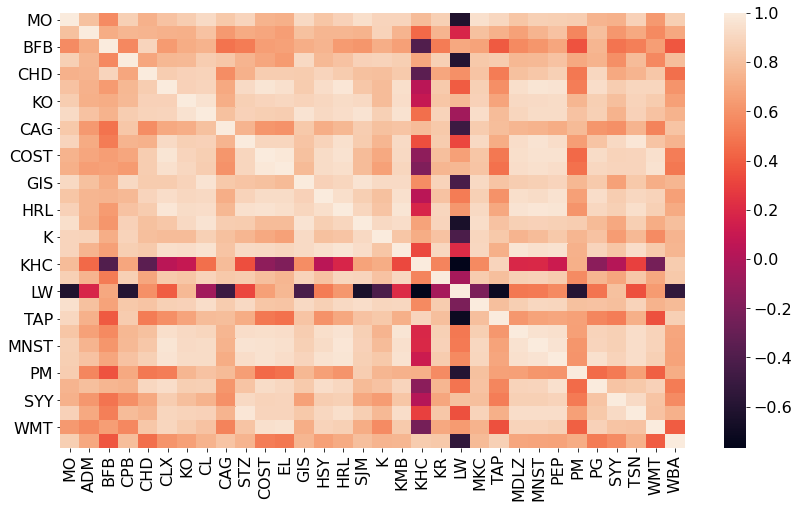

In [32]:
sns.heatmap(temp[-5])

In [35]:
good_dataset = by_sector[-5]
good_dataset

,MO,ADM,BFB,CPB,CHD,CLX,KO,CL,CAG,STZ,COST,EL,GIS,HSY,HRL,SJM,K,KMB,KHC,KR,LW,MKC,TAP,MDLZ,MNST,PEP,PM,PG,SYY,TSN,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,5.42,10.88,15.37,37.25,8.67,49.19,28.19,31.12,22.88,6.23,43.07,24.78,17.22,23.19,5.03,NaN,29.88,60.25,NaN,9.47,NaN,13.97,25.34,NaN,0.09,36.88,NaN,53.18,19.06,16.06,66.81,28.56
2000-01-04,5.47,10.77,15.08,35.88,8.46,47.88,28.22,30.31,22.44,5.99,40.71,24.34,16.91,22.31,4.96,NaN,28.81,59.72,NaN,9.78,NaN,14.16,25.03,NaN,0.09,35.94,NaN,52.16,18.47,16.00,64.31,27.50
2000-01-05,5.44,10.60,15.20,35.56,8.46,49.12,28.47,29.28,22.06,6.20,41.41,23.52,16.81,22.41,5.04,NaN,28.56,59.42,NaN,9.94,NaN,14.28,26.22,NaN,0.09,35.06,NaN,51.17,18.62,16.06,63.00,27.81
2000-01-06,5.34,10.66,15.30,36.31,8.75,49.56,28.50,29.22,22.69,6.44,42.24,24.22,16.78,23.00,5.12,NaN,28.81,60.31,NaN,9.56,NaN,14.09,25.91,NaN,0.09,36.62,NaN,53.52,19.41,16.19,63.69,27.00
2000-01-07,5.48,10.83,15.47,37.00,9.08,52.31,30.38,30.97,23.19,6.62,45.04,25.06,16.81,23.06,5.17,NaN,29.25,62.07,NaN,9.47,NaN,14.03,26.47,NaN,0.09,37.62,NaN,57.80,19.44,16.94,68.50,27.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,41.72,49.44,78.03,48.55,86.86,203.80,53.44,85.04,36.38,215.81,364.58,260.95,59.13,149.95,47.17,116.09,61.78,133.89,34.98,31.53,77.65,93.47,45.47,57.85,89.81,145.06,82.51,137.72,72.42,64.79,143.50,39.62
2020-12-28,41.48,49.70,78.35,48.43,87.48,202.25,54.16,85.41,36.62,218.64,371.06,263.82,59.35,151.80,47.22,116.33,62.34,133.95,35.21,31.39,77.44,93.42,45.48,58.27,90.81,146.91,82.49,138.68,73.83,64.38,145.22,39.66
2020-12-29,40.73,49.45,78.94,48.42,87.08,201.76,54.13,85.03,36.42,217.44,372.72,262.75,59.15,151.44,46.75,115.33,62.29,134.13,34.90,31.46,76.84,94.82,45.54,58.45,91.04,147.42,81.87,138.42,72.83,63.50,144.30,39.41


In [36]:
good_dataset.drop(columns='KHC', inplace=True)
good_dataset.drop(columns='LW', inplace = True)

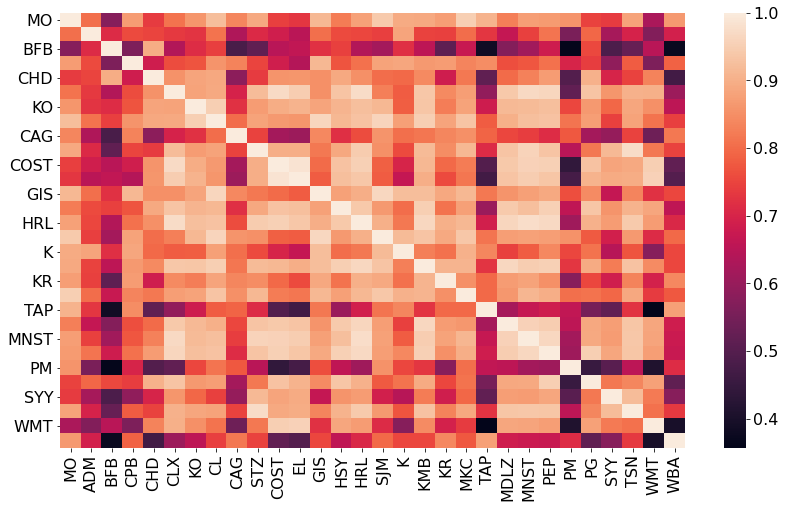

In [37]:
corr_good = good_dataset.corr()
sns.heatmap(corr_good)

In [38]:
corr_good.mean().mean()

0.802997587649081

In [39]:
train_list = list(good_dataset.columns)

In [40]:
train_list[0]

'MO'

In [41]:
train_list[1]

'ADM'

In [126]:
df_MO = get_data('MO')
df_ADM = get_data('ADM')

In [127]:
df_MO.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2000-01-03,5.42,5.45,5.54,5.37,7390000.0,0.0188
2000-01-04,5.47,5.38,5.61,5.38,10540000.0,0.0092
2000-01-05,5.44,5.51,5.57,5.42,11700000.0,-0.0055
2000-01-06,5.34,5.44,5.48,5.32,7150000.0,-0.0184
2000-01-07,5.48,5.38,5.51,5.35,7970000.0,0.0262


In [129]:
a = pd.concat([df_MO, df_ADM])

# 연속적이게 학습 시키는 방법?

In [16]:
class StockDataset(Dataset):
    
    def __init__(self, data, x_frames, y_frames, start, end):
        self.x_frames = x_frames
        self.y_frames = y_frames

        self.start = start
        self.end = end

        self.data = data.loc[self.start : self.end]


    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['Close','Open', 'High', 'Low', 'Volume', 'Change']]
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [42]:
df_list = []
for sym in train_list:
    df = get_data(sym)
    df = Min_Max_Scaler(df)
    df_list.append(df)

In [43]:
dataset_list = []

for data in df_list:
    data_set = StockDataset(data, 5, 1, '2000-01-01', '2020-01-01')
    dataset_list.append(data_set)

In [44]:
valid_list = []

for data in df_list:
    data_set = StockDataset(data, 5, 1, '2020-01-01', '2020-12-31')
    valid_list.append(data_set)

In [45]:
partition = {'train': dataset_list,
             'valid': valid_list}

### ES

In [152]:
class EarlyStopping:
    def __init__(self, args):
        self.patience = args.patience
        self.counter = 0
        self.best_score = None
        self.best_val_acc = None
        self.best_train_acc = None
        self.val_loss_min = np.Inf
        self.early_stop = False


        # self.hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

        if not os.path.isdir(args.path):
            os.mkdir(args.path)

    def __call__(self, val_loss, val_acc, train_acc, model, optimizer):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
            }, args.path+'t-model.pt')

            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc

            self.counter = 0

            print('Validation loss decreased --- Saving model ...')

            # torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')

            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
            },args.path+'t-model.pt')

            self.val_loss_min = val_loss

### LSTM

In [52]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

### train valid test

In [58]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

def train(model, partition, optimizer, loss_fn, args):
    # trainloader = DataLoader(partition['train'], 
    #                          batch_size=args.batch_size, 
    #                          shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0

    len_dataset = len(partition['train'])
    index_dataset = list(range(len_dataset))
    np.random.shuffle(index_dataset)

    for i in index_dataset:
        dataset = partition['train'][i]
        trainloader = DataLoader(dataset, batch_size= args.batch_size, shuffle=True, drop_last=True)
        for i, (X, y) in enumerate(trainloader):

            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()
            
            model.zero_grad()
            optimizer.zero_grad()
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]


            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / ((len(trainloader)*len_dataset) + 1e-7)
    train_acc = train_acc / ((len(trainloader)*len_dataset) + 1e-7)
    return model, train_loss, train_acc

def validate(model, partition, loss_fn, args):
    # valloader = DataLoader(partition['val'], 
    #                        batch_size=args.batch_size, 
    #                        shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        len_validset = len(partition['valid'])
        index_validset = list(range(len_validset))
        np.random.shuffle(index_validset)

        for i in index_validset:
            validset = partition['valid'][i]
            valloader = DataLoader(validset, batch_size= args.batch_size, shuffle=True, drop_last=True)       

            for i, (X, y) in enumerate(valloader):
                X = X.to(args.device)
                y = y.to(args.device)

                X = X.transpose(0, 1).float()
                y_true = y[:, :, 0].float()

                model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

                y_pred = model(X)
        
                loss = loss_fn(y_pred.view(-1), y_true.view(-1))

                val_loss += loss.item()
                val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / ((len(valloader)*len_validset) + 1e-7)
    val_acc = val_acc / ((len(valloader)*len_validset) + 1e-7)
    return val_loss, val_acc

### test

In [65]:
def test(model, data, start, end, args):
    data_scaled = Min_Max_Scaler(data)

    testset = StockDataset(data_scaled, args.x_frames, args.y_frames, start, end)

    testloader = DataLoader(testset, 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    
    test_t = data.loc[start:end]
    test_ind = test_t.index
    
    d_min = np.min(data, 0)
    d_max = np.max(data, 0)

    model.to(args.device)
    model.eval()    

    test_acc = 0.0
    prediction = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()
            
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

            temp = []
            y = y_pred.cpu().detach().numpy()

            for i in range(len(y)):
                temp.append(y[i].item())

            prediction = prediction + temp


    test_acc = test_acc / (len(testloader) + 1e-7)

    len_pred = len(prediction)
    len_ind = len(test_ind)

    temp_ind = len_pred - len_ind
    ind = test_ind[:temp_ind]

    true_y = data.loc[ind[0]:ind[-1]]['Close']
    true_y = pd.DataFrame(true_y)

    test_df = pd.DataFrame({"Close": prediction}, index=ind)


    acc = mean_absolute_error(Min_Max_Scaler(true_y), test_df, multioutput='raw_values') * 100
    test_df = return_data(test_df, d_min[0], d_max[0])


    return test_df, true_y, acc

### experiment

In [170]:
def experiment(partition, args, load = False):
    # hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice. Choose one of SGD, RMSprop, Adam')

    if load:
        model, optimizer = load_model(args)
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
        



    model.to(args.device)

    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
    
    early_stopping = EarlyStopping(args)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        start = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        end = time.time()

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch+1, train_acc, val_acc, train_loss, val_loss, end-start))

        early_stopping(val_loss, val_acc, train_acc, model, optimizer)

        if early_stopping.early_stop:
            print("Early Stopping!!")
            val_loss = early_stopping.val_loss_min
            val_acc = early_stopping.best_val_acc
            train_acc = early_stopping.best_train_acc
            end = time.time()
            break
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #


    model, _ = load_model(args)
    

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = [x for x in train_losses]
    result['val_losses'] = [x for x in val_losses]
    result['train_accs'] = [x for x in train_accs]
    result['val_accs'] = [x for x in val_accs]
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    
    return model, vars(args), result

In [153]:
def load_model(args):
    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

    checkpoint = torch.load(args.path+'t-model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


    return model, optimizer

### parser

In [47]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(args.device)

cuda:0


In [48]:
args.batch_size = 64
args.x_frames = 5
args.y_frames = 1

# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 1

# ====== Regularization ======= #
args.l2 = 0.0001
args.dropout = 0.3
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100
args.patience = 10
args.path = '/content/gdrive/MyDrive/model_checkpoint/'

## Let's Train!

In [178]:
model, setting, result = experiment(partition, deepcopy(args))

Epoch 1, Acc(train/val): 12.50/14.00, Loss(train/val) 0.01589/0.00875. Took 110.43 sec
Validation loss decreased (inf --> 0.0088).  Saving model ...
Epoch 2, Acc(train/val): 8.09/6.44, Loss(train/val) 0.00571/0.00191. Took 111.81 sec
Validation loss decreased --- Saving model ...
Epoch 3, Acc(train/val): 7.29/20.79, Loss(train/val) 0.00467/0.01354. Took 113.87 sec
EarlyStopping counter: 1 out of 10
Epoch 4, Acc(train/val): 7.89/5.59, Loss(train/val) 0.00471/0.00129. Took 112.81 sec
Validation loss decreased --- Saving model ...
Epoch 5, Acc(train/val): 6.85/4.25, Loss(train/val) 0.00409/0.00091. Took 114.09 sec
Validation loss decreased --- Saving model ...
Epoch 6, Acc(train/val): 6.54/5.05, Loss(train/val) 0.00383/0.00116. Took 114.41 sec
EarlyStopping counter: 1 out of 10
Epoch 7, Acc(train/val): 6.06/7.39, Loss(train/val) 0.00326/0.00179. Took 115.59 sec
EarlyStopping counter: 2 out of 10
Epoch 8, Acc(train/val): 5.94/6.35, Loss(train/val) 0.00300/0.00162. Took 116.98 sec
EarlyStop

# Test

In [53]:
def load_model(args):
    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)

    checkpoint = torch.load(args.path+'t-model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


    return model, optimizer

In [60]:
def plot_test(test_y, true_y, name):
    plt.figure(figsize=(10,10))
    plt.title(f"Prediction VS Real --- {name}")
    plt.plot(test_y, color='b')
    plt.plot(true_y, color='r')
    plt.legend(["Prediction", "True"],loc='upper left')
    # plt.show()
    plt.savefig(f'/content/gdrive/MyDrive/Images3/{name}.png', dpi=300)
    plt.clf()

In [55]:
model, _ = load_model(args)

In [ ]:
acc_list = []
acc_dict = {}

for name in train_list:
    print(name+' testing start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.1)

    start = df.index[-split]
    end = df.index[-1]

    if len(df.loc[start:end]) < args.batch_size:
        start = "2020-01-01"
        end = "2020-12-24" 

    test_y, true_y, acc = test(model, df, start, end, args)
    acc_list.append(acc)
    acc_dict[name] = acc

    plot_test(test_y, true_y, name)

In [70]:
import json

filename = '/content/gdrive/MyDrive/results/Consumer_Staples.json'
with open(filename, 'w') as f:
    json.dump(acc_dict, f)

In [71]:
filename = '/content/gdrive/MyDrive/results/Consumer_Staples.json'

with open(filename, 'r') as f:
    result = json.load(f)

In [72]:
result_df = pd.DataFrame(data = list(result.values()), index = list(result.keys()), columns = ["Accuracy"]) 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


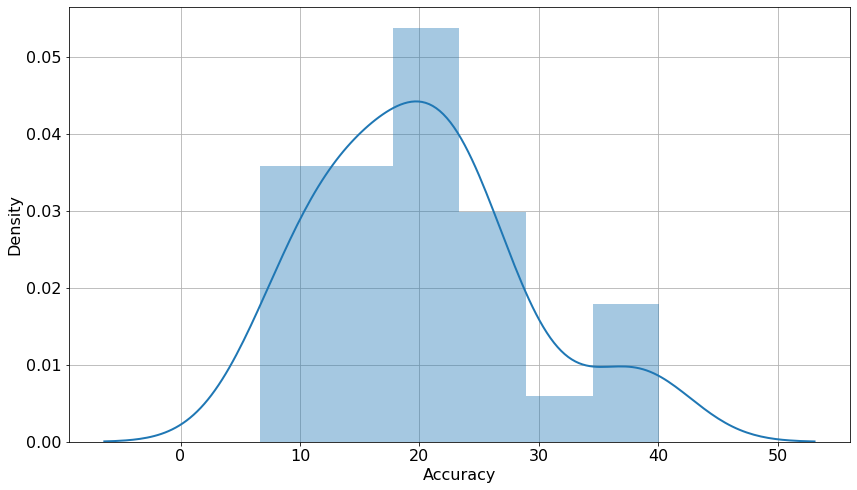

In [73]:
sns.distplot(result_df['Accuracy'])

In [74]:
minValue = result_df.min().item()
maxValue = result_df.max().item()

minName = result_df.idxmin().item()
maxName = result_df.idxmax().item()

meanScore = result_df.mean().item()
std = result_df.std().item()

print(f'Best Prediction: {minName} -- {minValue:.2f}')
print(f"Worst Prediction: {maxName} --{maxValue:.2f}")
print(f"Meam Score: {meanScore:.2f}")

Best Prediction: WBA -- 6.63
Worst Prediction: HRL --40.07
Meam Score: 20.07
